## PyTorch End to End Workflow

In [217]:
import torch
from torch import nn ## nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

#check pytorch version
torch.__version__

'1.12.1'

### 1. Data Loading and Preparing
* Create _known_ **parameters** using linear regression
* Y = a + b * x

In [218]:
# Create known parameters
weight = 0.7
bias = 0.3

# Create range of numbers
start = 0
end = 1
step = 0.02
# X (capital) is a matrix or tensor in machine learning
# Unsqueezed in next line adds another dimension
X = torch.arange(start, end, step).unsqueeze(dim=1) 
y = weight * X + bias

X[:10], y[:10]    # Display first 10 values

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [219]:
# Splitting data into training and test data is one of the most important concept of machine learning
# Creating 2 or 3 sets: Training Set (75% data), Validation Set (15%), Testing Set (15%)

len(X), len(y)

(50, 50)

In [220]:
# There are 50 sets, so lets make 80/20 split train/test

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [266]:
def plot_predictions(train_data = X_train, 
                    train_labels = y_train, 
                    test_data = X_test,
                    test_labels = y_test,
                    predictions = None):
    """
    Plots training data, test data, compares predictions.
    """
    plt.figure(figsize = (10, 7))
    # Plot training in blue
    plt.scatter(train_data, 
                train_labels, 
                c="b", 
                s=4, 
                label="Training data")
    # Plot test data in green
    plt.scatter(test_data, 
                test_labels, 
                c="g", 
                s=4, 
                label="Test data")
    # Are there predictions? If yes, plot
    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', label='Predictions')
    
    #Show legent
    plt.legend(prop={'size': 14});    

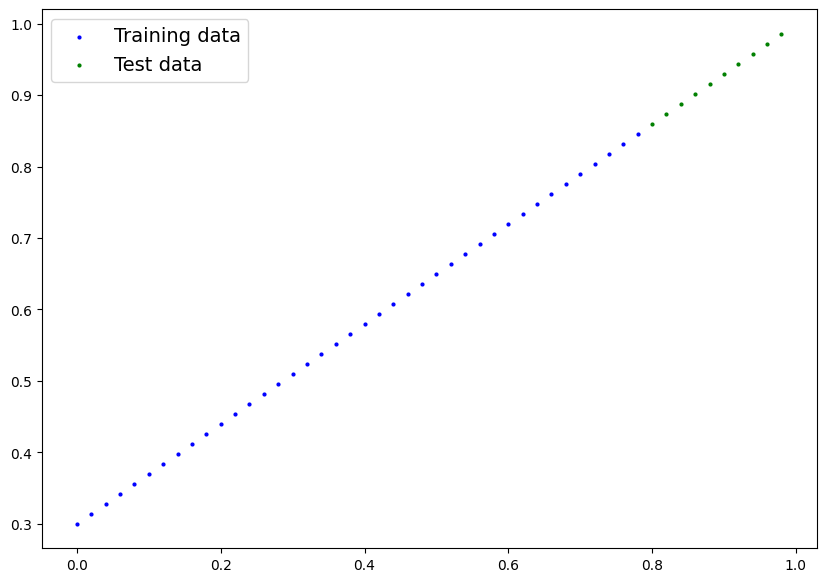

In [222]:
plot_predictions()

### 2. Build PyTorch Model

In [223]:
from torch import nn

# Create linear regression model class
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()        
        self.weights = nn.Parameter(torch.randn(1, 
                                                requires_grad=True, 
                                                dtype=torch.float
        ))

        self.bias = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float # <- PyTorch loves float32 by default
        ))
        
    #Forward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

In [224]:
# Create random seed for our model for consistency
torch.manual_seed(42)

# create an instance of lin reg model
model_0 = LinearRegressionModel()
# check parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [225]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using 'torch.inference_mode()'

In [226]:
with torch.inference_mode():
    y_preds = model_0(X_test)
    
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

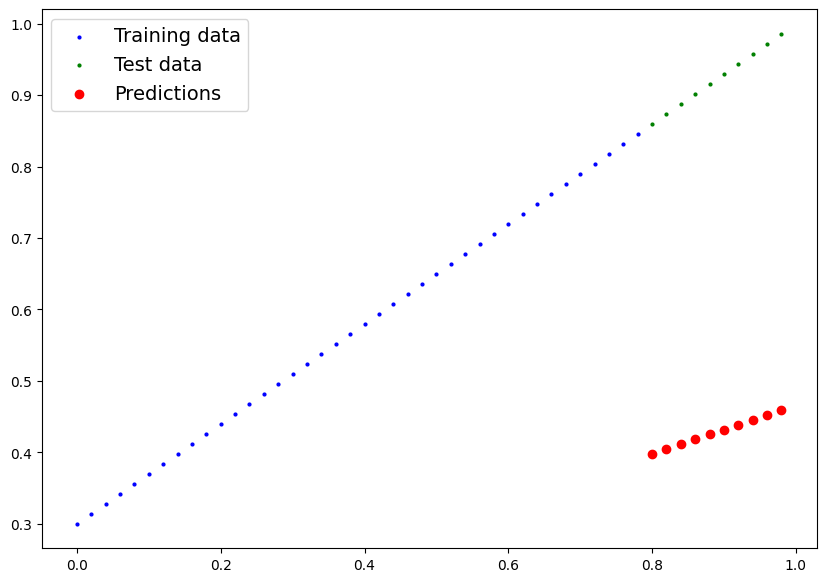

In [227]:
plot_predictions(predictions = y_preds)

#### How to make inference code in PyTorch run faster:
https://twitter.com/PyTorch/status/1437838231505096708?s=20&t=cnKavO9iTgwQ-rfri6u7PQ

### Loss Function
* **Loss function**: measures how wrong your model's predictins are to the ideal output
* **Optimizer**: takes into account the loss of model and adjusts the model's parameters to improve the loss function


In [228]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [229]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr=0.01) # learning rate = most important hyperparameter



### Building a training loop (and testing loop) in PyTorch
0. Loop through the data
1. Forward pass
2. Calculate the loss
3. Optimize the zero grad
4. Loss backward
5. Optimizer step

In [230]:
# An epoch is one loop through the data...
epochs = 200

# Track different values
epoch_count = []
loss_values = []
test_loss_value = []

# 0. Loop through the data
for epoch in range(epochs):
    # set model to training mode
    model_0.train() #trains model in PyTorch

    # 1. Forward Pass
    y_pred = model_0(X_train)
    
    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)
    
    # 3. Optimize the zero grad
    optimizer.zero_grad()
    
    # 4. Perform backpropagation
    loss.backward()
    
    #5. Step the optimizer
    optimizer.step()
        
    #6. Testing
    model_0.eval() #Turns off gradient tracking
    with torch.inference_mode():
        # FORWARD PASS for test
        test_pred = model_0(X_test)
    
        # calculate the loss
        test_loss = loss_fn(test_pred, y_test)
    
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_value.append(test_loss)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}  | Loss: {loss} | Test loss: {test_loss}")
        print(model_0.state_dict())
    
    

Epoch: 0  | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10  | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20  | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30  | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40  | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50  | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60  | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor(

In [231]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

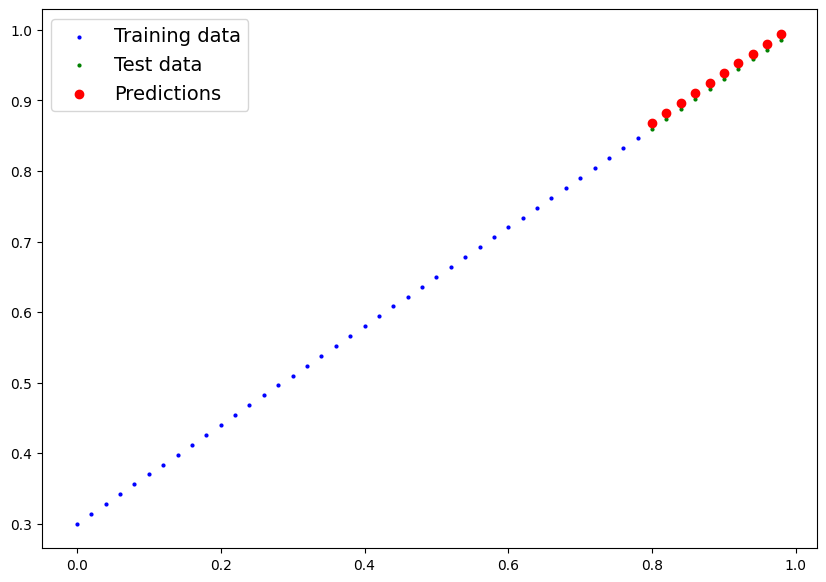

In [232]:
plot_predictions(predictions=y_preds_new)

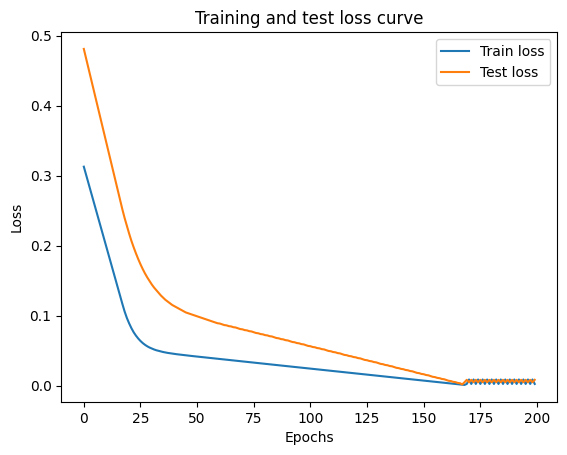

In [233]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the loss curves
loss_values_np = np.array(torch.tensor(loss_values).numpy())
plt.plot(epoch_count, loss_values_np, label="Train loss")
plt.plot(epoch_count, test_loss_value, label="Test loss")
plt.title("Training and test loss curve")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

### Saving a Model in PyTorch
There are 3 main methods for saving and loading models in PyTorch

1. torch.save() - allows you to save a PyTorch object in Python's pickle format
2. torch.load() - allows you to load a PyTorch object
3. torch.nn.Module.load_state_dict() - this allows you to load a model's saved state dictionary

In [242]:
# Saving PyTorch model

from pathlib import Path

# 1 - create model directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok="True")

# 2 - create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3 - save
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_0.state_dict(), f = MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [243]:
## Loading a PyTorch model

from pathlib import Path

# To load a saved state_dict(), we must instatiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()
loaded_model_0.state_dict()  #see it is a random model of lin reg

OrderedDict([('weights', tensor([0.5349])), ('bias', tensor([0.8094]))])

In [244]:
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH)) #load actual data
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [245]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [247]:
# Make some models
model_0.eval()
with torch.inference_mode():
    y_preds = model_0(X_test)


In [248]:
# Comapre loaded model preds with original model preds
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# 6. Putting it all together

### 6.0 Imports

In [330]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# Create device agnostc code | use GPU if available, else CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    !nvidia-smi   #if cuda, display nvidia specs (ie. if using colab)

Using device: cpu


### 6.1 Data

In [331]:
# Create some data using lin regression for of y = w * X + b
weight = 0.7
bias = 0.3

# Create range of values
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
print(f"X: {X[:10]}\ny: {y[:10]}")

X: tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]])
y: tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560],
        [0.3700],
        [0.3840],
        [0.3980],
        [0.4120],
        [0.4260]])


In [332]:
# Split data to train and test
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test =  X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [333]:
def plot_predictions(train_data = X_train, 
                    train_labels = y_train, 
                    test_data = X_test,
                    test_labels = y_test,
                    predictions = None):
    """
    Plots training data, test data, compares predictions.
    """
    plt.figure(figsize = (10, 7))
    # Plot training in blue
    plt.scatter(train_data, 
                train_labels, 
                c="b", 
                s=4, 
                label="Training data")
    # Plot test data in green
    plt.scatter(test_data, 
                test_labels, 
                c="g", 
                s=4, 
                label="Test data")
    # Are there predictions? If yes, plot
    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', label='Predictions')
    
    #Show legent
    plt.legend(prop={'size': 14});    

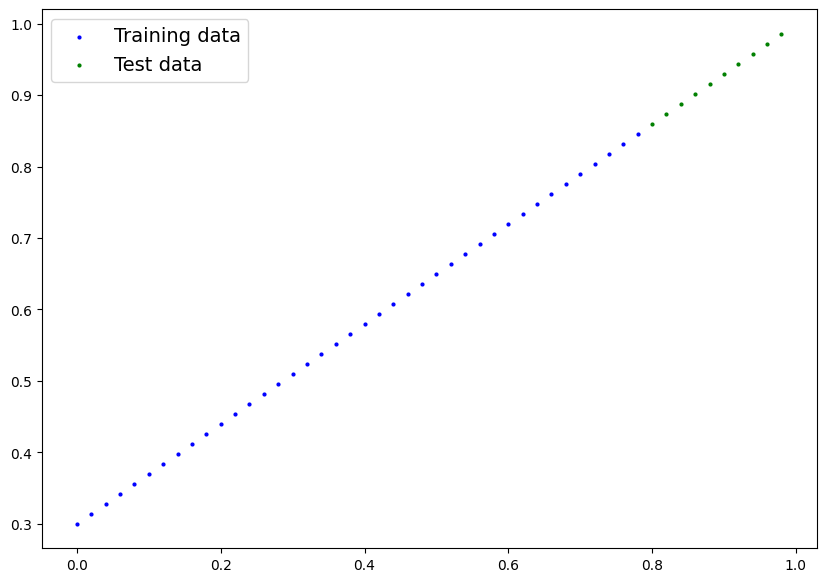

In [334]:
# Plot the data
plot_predictions(X_train, y_train, X_test, y_test)

### 6.1 Building a PyTorch Linear Model

In [352]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # use built in nn.Linear() layer to create random parameters
        self.linear_layer = nn.Linear(in_features=1,
                                     out_features=1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)
    
# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

### 6.2 Training the PyTorch Model

In [355]:
# Setup loss function
loss_fn = nn.L1Loss()  # same as MAE

# Setup our optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.02)

In [356]:
# Write a training loop
torch.manual_seed(42)

# Put data on the target device (CPU or GPU)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

epochs = 600
for epoch in range(epochs):
    model_1.train()
    
    # 1. Forward pass
    y_pred = model_1(X_train)
    
    # 2. Calc the loss
    loss = loss_fn(y_pred, y_train)
    
    # 3. Optimize
    optimizer.zero_grad()
    
    # 4. Backpropagation
    loss.backward()
    
    # 5. Optimizer step
    optimizer.step()
    
    # 6. Testing
    model_1.eval()
    with torch.inference_mode():
        test_pred = model_1(X_test)
        
        test_loss = loss_fn(test_pred, y_test)
    
    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    

Epoch: 0 | Loss: 0.5551779866218567 | Test loss: 0.5605052709579468
Epoch: 100 | Loss: 0.008968479931354523 | Test loss: 0.0115931686013937
Epoch: 200 | Loss: 0.008968479931354523 | Test loss: 0.0115931686013937
Epoch: 300 | Loss: 0.008968479931354523 | Test loss: 0.0115931686013937
Epoch: 400 | Loss: 0.008968479931354523 | Test loss: 0.0115931686013937
Epoch: 500 | Loss: 0.008968479931354523 | Test loss: 0.0115931686013937


In [357]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6872]])),
             ('linear_layer.bias', tensor([0.2960]))])

In [358]:
weight, bias

(0.7, 0.3)

### 6.4 Making and evaluating predictions

In [359]:
# Turn model into eval mode for predctions, train mode for training
model_1.eval()

# Make predictions on test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8458],
        [0.8595],
        [0.8733],
        [0.8870],
        [0.9008],
        [0.9145],
        [0.9283],
        [0.9420],
        [0.9558],
        [0.9695]])

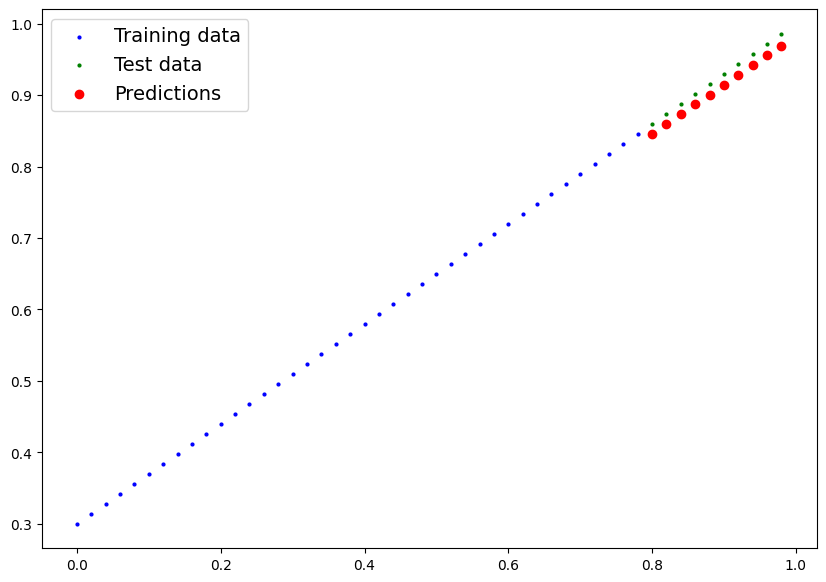

In [360]:
# Check out our models visually
# Because Matplotlip uses CPU, we must ensure dataset is on CPU
plot_predictions(predictions=y_preds.cpu())

### 6.5 Saving and loading trained model

In [316]:
from pathlib import Path

# 1. create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok="True")

# 2. create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. save
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_1.state_dict(), f = MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [317]:
# Load from disk and plot
loaded_model_1 = LinearRegressionModelV2()   #an instance of nn.Module
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put loaded model to device if exists
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [319]:
next(loaded_model_1.parameters()).device

device(type='cpu')

In [320]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6936]])),
             ('linear_layer.bias', tensor([0.2980]))])

In [321]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])